# Run all Code Boxes From Here until marked

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
import tifffile
from scipy.spatial import KDTree

import os
import pandas as pd
from sklearn.cluster import DBSCAN
from tkinter import filedialog
from tkinter import Tk

from sklearn.cluster import DBSCAN
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import warnings

In [2]:
# Open the TIFF movie
with tifffile.TiffFile('Examples/B1_Composite.tif') as tif:
    # Get the number of frames in the movie
    n_frames = len(tif.pages)

    # Read all frames of the movie and store them as a numpy array
    movie = np.zeros((n_frames, tif.pages[0].shape[0], tif.pages[0].shape[1]), dtype='uint16')
    for i in range(n_frames):
        movie[i,:,:] = tif.pages[i].asarray()

    # Print relevant information about the movie
    print('Number of frames: {}'.format(n_frames))
    print('Shape of each frame: {}'.format(tif.pages[0].shape))
    print('Data type of each pixel: {}'.format(tif.pages[0].dtype))

# Display the first frame of the movie
# plt.figure()
# plt.imshow(movie[0,:,:])
# plt.show()

life_act = movie[0]

Number of frames: 4
Shape of each frame: (2560, 2560)
Data type of each pixel: float32


In [127]:
## Helper Functions
def plot_scale_bar(nm_per_pixel):
    fontprops = fm.FontProperties(size=8)
    scalebar = AnchoredSizeBar(plt.gca().transData,
                            1000/nm_per_pixel,  # length of scale bar
                            '1 micron',  # label
                            'lower right',  # position
                            pad=0.1,
                            color='white',
                            frameon=False,
                            size_vertical=0.05,
                            fontproperties=fontprops)
    plt.gca().add_artist(scalebar)

In [175]:
class Frames():
    def __init__(self, frames, time_per_frame):
        self.frames = np.array(frames)
        self.time_per_frame = time_per_frame
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        return self.frames[idx]
    
    def __max__(self):
        return max(self.frames)
    
    def __min__(self):
        return min(self.frames)

In [218]:
class BasePoints:
    def __init__(self, points, frames=None, nm_per_pixel=1, **kwargs):
        self.label = kwargs.get('label')
        self.frames = frames
        self.nm_per_pixel = nm_per_pixel
        self.points = np.array(points)
        self.plot_args = kwargs

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx]

    def set_plot_args(self, **kwargs):
        self.plot_args = kwargs
        
    def add_to_plot(self, **kwargs):
        args = {**self.plot_args, **kwargs}
        plt.scatter(self.points[:, 0], self.points[:, 1], **args)

    def plot(self, **kwargs):
        args = {**self.plot_args, **kwargs}
        if args.get('color') == 'white':
            args['color'] = 'black'
        plt.figure()
        self.add_to_plot(**args)
        if self.label is not None:
            plt.title(self.label)
        plt.show()


class SubPoints(BasePoints):
    def __init__(self, base_points, indices, **kwargs):
        super().__init__(base_points[indices], base_points.frames, base_points.nm_per_pixel, **kwargs)
        self.indices = np.array(indices)
        if self.frames is not None:
            self.frames = Frames(self.frames[indices], self.frames.time_per_frame)
        self.plot_args = {**base_points.plot_args, **self.plot_args}
        self.base_points = base_points

    def get_base_index(self, idx):
        return self.indices[idx]

In [222]:
class Cluster(SubPoints):
    def __init__(self, base_points, indices, fov=None, nearby_points=None, **kwargs):
        super().__init__(base_points, indices, **kwargs)
        self.cluster_center = self.points.mean(axis=0)
        self.fov = fov
        self.nearby_points = nearby_points
    
    def __str__(self):
        return f"ClusterAt{self.cluster_center})"
    
    def __repr__(self):
        return f"ClusterAt{self.cluster_center})"
    
    def distance_from(self, point):
        return np.linalg.norm(self.cluster_center - point)

    def plot_life_act(self, life_act):
        if type(life_act) != bool:
            plt.imshow(life_act, cmap='hot', origin='lower')
        elif life_act:
            if self.fov is None:
                print("No FOV attached to cluster, cannot plot life_act")
            else:
                if self.fov.life_act is None:
                    print("FieldOfView.life_act = None")
                    return
                plt.imshow(self.fov.life_act, cmap='hot', origin='lower')

    def plot_homers(self, homers):
        if type(homers) != bool:
            if type(homers) != BasePoints:
                homers_type = f"type(homers)"
                raise Exception(f"'homers' is not of class BasePoints, instead " + homers_type)
            homers.add_to_plot()
        elif homers:
            if self.fov is None:
                print("No FOV attached to cluster, cannot plot homers")
            else:
                if self.fov.all_homer_centers is None:
                    print("FieldOfView.all_homer_centers = None")
                    return
                self.fov.all_homer_centers.add_to_plot()
    
    def plot(self, buffer=100, print_center=True, legend=True, scale_bar=True, time_limits=None,
                     nearby_points=False, all_points=False, homers=True, life_act=True, **kwargs):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)

        nm_per_pixel = self.nm_per_pixel
        cluster_points = self.points
        cluster_center = self.cluster_center
        self.plot_life_act(life_act)
        if all_points:
            self.base_points.add_to_plot()
        if nearby_points:
            self.nearby_points.add_to_plot()
        self.add_to_plot(**kwargs) # Plots this cluster
        self.plot_homers(homers)
        if print_center:
            plt.scatter(cluster_center[0], cluster_center[1], marker='x', linewidth=10, s=5, color='red', label="Cluster Center")
        
        if scale_bar:
            plot_scale_bar(nm_per_pixel)
        if life_act:
            plt.title(f"{self.label} [Background: Life_act]")
        else:
            plt.title(f"{self.label}")
        if legend:
            # Increase icon sizes in legend so you can actually see the points
            for handle in plt.legend().legend_handles:
                handle._sizes = [50]
        buffer = buffer / nm_per_pixel
        plt.xlim(np.min(cluster_points[:, 0]) - buffer, np.max(cluster_points[:, 0]) + buffer)
        plt.ylim(np.min(cluster_points[:, 1]) - buffer, np.max(cluster_points[:, 1]) + buffer)
        
        # Timeline plot
        plt.subplot(1, 2, 2)
        cluster_frames = self.frames.frames
        time_per_frame = self.frames.time_per_frame
        frame_range = range(max(self.base_points.frames))
        times = [frame*time_per_frame for frame in frame_range]
        vals = [1 if frame in cluster_frames else 0 for frame in frame_range]
        plt.plot(times, vals)
        plt.title(f"Timeline for {self.label} [{len(cluster_frames)} events]")
        plt.xlabel("Time (s)")
        plt.ylabel("On [1] or Off [0]")
        plt.ylim(0, 1.3)
        if time_limits is not None:
            plt.xlim(time_limits[0], time_limits[1])
        plt.tight_layout()
        plt.show()

class ClusterParam():
    def __init__(self, eps, min_samples, label=""):
        self.eps = eps
        self.min_samples = min_samples
        self.params = (eps, min_samples)
        self.density = min_samples / (np.pi * (eps ** 2))
        self.label=label

    def __eq__(self, other):
        if not isinstance(other, ClusterParam):
            return NotImplemented
        return self.eps == other.eps and self.min_samples == other.min_samples and self.label == other.label
    
    def __lt__(self, other):
        return self.density < other.density
    
    def __gt__(self, other):
        return self.density > other.density
    
    def __le__(self, other):
        return self.density <= other.density
    
    def __ge__(self, other):
        return self.density >= other.density
    
    def __str__(self):
        return f"{self.label}(eps={self.eps}, min_samples={self.min_samples})"
    
    def __repr__(self):
        return f"{self.label}(eps={self.eps}, min_samples={self.min_samples})"
    
    def __hash__(self):
        return hash((self.eps, self.min_samples, self.label))
    
    def __getitem__(self, idx):
        if idx == 0:
            return self.eps
        elif idx == 1:
            return self.min_samples
        else:
            raise IndexError("Only indices 0 (eps) and 1 (min_samples) are valid for ClusterParam")

In [178]:
def locate_homer_centers(path, plot=False):
    # Step 1: Load post-synaptic marker (e.g., Homer, PSD95) ThunderSTORM data
    outputindex = os.path.basename(os.path.dirname(path))
    dim = 2
    picasso = 0  # if Picasso = 1, otherwise = 0
    synapse_size = 50  # cluster size in nm
    min_neighbours = 5  # minimum number of neighbours w/n synapse_size radius for cluster filtering

    root = Tk()
    root.withdraw()
    # file_path = filedialog.askopenfilename(initialdir=path, title="Select the Homer (or synaptic marker) file to process",
    #                                        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
    file_path = r"C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples\B1_aHomer_corrected.csv"

    try:
        ThunderSTORM1 = pd.read_csv(file_path, sep=',', skiprows=1, header=None)
    except Exception:
        ThunderSTORM1 = pd.read_excel(file_path, header=None)

    if picasso == 1:
        ThunderSTORM1.iloc[:, 1] = ThunderSTORM1.iloc[:, 1] + 1

    ThunderSTORM = [ThunderSTORM1.values]
    if dim == 3:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        palmZ = ThunderSTORM[0][:, 4]
        data_Syn = np.column_stack((palmX, palmY, palmZ))
    elif dim == 2:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        data_Syn = np.column_stack((palmX, palmY))

    # Finding clusters
    db = DBSCAN(eps=synapse_size, min_samples=min_neighbours, metric='euclidean').fit(data_Syn)
    Class = db.labels_
    type_ = np.array([1 if label != -1 else 0 for label in Class])

    # Make new matrix
    cluster_avgs = []
    if dim == 3:
        Syn = np.column_stack((palmX, palmY, 0.79 * palmZ, Class, type_))
        # Separate and plot clusters
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 3] == k]
                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=20)
    elif dim == 2:
        Syn = np.column_stack((palmX, palmY, Class, type_))
        # Separate and plot clusters
        if plot: plt.figure()

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 2] == k]
                cluster_avgs.append((sum(cluster_points[:, 0])/len(cluster_points[:, 0]), sum(cluster_points[:, 1])/len(cluster_points[:, 1])))
                if plot: plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20)
    if plot:
        plt.axis('equal')
        # plt.xlim(500, 570)
        # plt.ylim(39530, 39600)
        plt.show()
    return cluster_avgs

In [179]:
path = r'C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples'
nm_per_pixel = 21.34
homer_centers_nm = np.array(locate_homer_centers(path))
homer_centers_px = homer_centers_nm/nm_per_pixel
homer_centers_int = homer_centers_px.astype(int)
homer_centers = BasePoints(homer_centers_px, frames=None, nm_per_pixel=nm_per_pixel, marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")

In [180]:
# read the csv file into a pandas dataframe
GluA1_df = pd.read_csv(r'Examples\B1_GluA1_corrected.csv', delimiter=',')
GluA2_df = pd.read_csv(r'Examples\B1_GluA2_corrected.csv', delimiter=',')

# extract the x and y columns
raw_GluA1_x = GluA1_df['x [nm]']/nm_per_pixel
raw_GluA1_y = GluA1_df['y [nm]']/nm_per_pixel
GluA1_frames = Frames(np.array(GluA1_df['frame']), time_per_frame=0.1)

raw_GluA2_x = GluA2_df['x [nm]']/nm_per_pixel
raw_GluA2_y = GluA2_df['y [nm]']/nm_per_pixel
GluA2_frames = Frames(np.array(GluA2_df['frame']), time_per_frame=0.1)


# Reshape into points
raw_GluA1_pts = np.array(list(zip(raw_GluA1_x, raw_GluA1_y)))
GluA1 = BasePoints(raw_GluA1_pts, GluA1_frames, nm_per_pixel, s=0.75, color='white', label="GluA1")

raw_GluA2_pts = np.array(list(zip(raw_GluA2_x, raw_GluA2_y)))
GluA2 = BasePoints(raw_GluA2_pts, GluA2_frames, nm_per_pixel, s=0.75, color='yellow', label="GluA2")

In [219]:
class FieldOfView():
    def __init__(self, homer_centers, life_act, Points=[], Params=[], threshold=0):
        self.all_homer_centers = homer_centers
        self.life_act = life_act
        self.threshold_homers(threshold)
        if type(Points) != list:
            Points = [Points]
        self.Points = Points
        if type(Params) != list:
            Params = [Params]
        self.Params = []
        self.clustering_results = {}
        for Param in Params:
            print(f"Finding Clusters for: {Param}")
            self.find_clusters(Param)
    
    def find_instance_by_label(self, instances, target_label):
        for instance in instances:
            if instance.label == target_label:
                return instance
        return None

    def threshold_homers(self, threshold, plot=False):
        threshold_map = np.array(life_act > threshold)
        hc = self.all_homer_centers
        passed_indices = np.array([i for i in range(len(hc)) if threshold_map[int(hc[i][1]), int(hc[i][0])]])
        self.active_homers = SubPoints(self.all_homer_centers, passed_indices, **hc.plot_args)
        
        if plot:
            plt.figure()
            plt.imshow(self.life_act, origin='lower')
            self.all_homer_centers.add_to_plot()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

            plt.figure()
            plt.imshow(self.life_act*threshold_map, origin='lower')
            self.active_homers.add_to_plot()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

    def find_clusters(self, Param, nearby_radius=1500):
        Points = self.find_instance_by_label(self.Points, Param.label)
        if Points is None:
            raise Exception(f"Can not find {Param.label}")
        if Param not in self.Params:
            self.Params.append(Param)
        eps = Param.eps / Points.nm_per_pixel
        min_samples = Param.min_samples
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(Points.points)
        labels = clustering.labels_
        indices = np.arange(0, len(Points))
        clusters = []
        for i in range(np.max(labels) + 1):
            cluster_indices = indices[labels == i]
            clusters.append(Cluster(Points, cluster_indices, fov=self, s=0.75, color='aqua', label=f'Cluster {i}'))
        cluster_centers = [cluster.cluster_center for cluster in clusters]
        kdtree = KDTree(Points.points)
        # workers=-1 is for parallel processing, if running into problems, set to 1
        nearby_point_indices = kdtree.query_ball_point(cluster_centers, nearby_radius/Points.nm_per_pixel, workers=-1)
        for i in range(np.max(labels) + 1):
            clusters[i].nearby_points = SubPoints(Points, nearby_point_indices[i], label="Nearby " + Points.label)
        self.clustering_results[Param] = clusters
        return clusters
    
    def add_params(self, Params=[]):
        if type(Params) != list:
            Params = [Params]
        for Param in Params:
            print(f"Finding Clusters for: {Param}")
            self.clustering_results[Param] = self.find_clusters(Param)
    
    def plot_homer(self, idx, Params=[], circle_radii=[]):
        Homer = self.active_homers[idx]
        
        
        
        # homer_center = self.center
        # if radii is None:
        #     if list(self.regions.keys()) == []:
        #         raise Exception("No existing 'radii' and none provided")
        #     else:
        #         radii = list(self.regions.keys())
        #         warnings.warn(f"No radii provided to 'radii', using all current radii: {radii}")
        # if type(radii) != list: radii = [radii]
        # radii = sorted(radii, reverse=True)
        # for radius in radii:
        #     if radius not in list(self.regions.keys()):
        #         raise Exception(f"Provided an invalid radius of {radius} nm, this radius has not been processed yet")

        # if points_label is None:
        #     if self.points_labels == []:
        #         raise Exception("No existing labels, 'points_label' needs to be provided with a string labeling the points")
        #     else:
        #         points_label = self.points_labels[0]
        #         warnings.warn(f"No label provided to 'points_label', assuming points are of label '{points_label}'")
        
        # plt.figure(dpi=dpi)
        # # Plot Life Act Background
        # if life_act is not None:
        #     plt.imshow(life_act, cmap='hot', origin='lower')
        
        # # Set Plot Ranges
        # buffer_px = buffer / nm_per_pixel
        # vertical_buffer = (max(radii)/self.nm_per_pixel) + buffer_px
        # left_buffer = (max(radii)/self.nm_per_pixel) + 0.5*buffer_px
        # right_buffer = (max(radii)/self.nm_per_pixel) + 4*buffer_px
        # plt.xlim(homer_center[0] - left_buffer, homer_center[0] + right_buffer)
        # plt.ylim(homer_center[1] - vertical_buffer, homer_center[1] + vertical_buffer)
        
        # # Plot Background Points
        # if all_points is None:
        #     nearby_points = self.regions[max(radii)][points_label]['points']
        #     plt.scatter(nearby_points[:, 0], nearby_points[:, 1], s=size, color='white', label=f"All Points")
        # else:
        #     plt.scatter(all_points[:, 0], all_points[:, 1], s=size, color='white', label=f"All Points")
        
        # #Plot Regional Data (Circles, Clusters)
        # if len(radii) == 1:
        #     radius = radii[0]
        #     if circle_regions:
        #         plt.gca().add_artist(plt.Circle(homer_center, radius/self.nm_per_pixel, fill = False, color='red'))
        #     if clusters:
        #         if len(params) == 0:
        #             keys = list(self.regions[radius][points_label]['clustering'].keys())
        #             if len(keys) == 1:
        #                 params = keys
        #                 warnings.warn(f"'params' left blank, only one clustering parameter has been run, automatically showing param: {keys[0]}")
        #             else:
        #                 raise Exception("'params' left blank, multiple clustering parameters have been run. you need to provide the parameters of the clustering you want to display")
        #         params = sorted(params, key=lambda x: x[0], reverse=True)
        #         for i in range(len(params)):
        #             clusters = self.regions[radius][points_label]['clustering'][params[i]]
        #             cluster_level_points = []
        #             cluster_centers = []
        #             for center in clusters:
        #                 cluster_level_points.extend(clusters[center])
        #                 cluster_centers.append(center)
        #             cluster_level_points = np.array(cluster_level_points)
        #             cluster_centers = np.array(cluster_centers)
        #             if cluster_level_points.shape == (0, ):
        #                 print(f"No Clusters in radius [{radius} nm] and with (eps, min_samples) [{params[i]}]")
        #             else:
        #                 plt.scatter(cluster_level_points[:, 0], cluster_level_points[:, 1], color=colors[i], s=size, label=f"Cluster Level {i}")
        #             if plot_cluster_centers and cluster_level_points.shape != (0, ):
        #                 if i > 1:
        #                     warnings.warn("Cluster center plotting warning: code does not support plotting centers and multiple levels of cluster")
        #                 plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='cyan', s=40, marker='x', label=f"Cluster Centers")
        # else:
        #     if len(params) == 0:
        #         keys = list(self.regions[radius][points_label]['clustering'].keys())
        #         if len(keys) == 1:
        #             params = keys
        #             warnings.warn(f"'params' left blank, only one clustering parameter has been run, automatically showing param: {keys[0]}")
        #         else:
        #             raise Exception("'params' left blank, multiple clustering parameters have been run. you need to provide the parameters of the clustering you want to display")
        #     elif len(params) > 1:
        #         raise Exception("Currently no implementation for multiple radii and multiple levels of clustering")
        #     param = params[0]
        #     for i in range(len(radii)):
        #         radius = radii[i]
        #         if circle_regions:
        #             plt.gca().add_artist(plt.Circle(homer_center, radius/self.nm_per_pixel, fill = False, color=colors[i]))
        #         if clusters:
        #             clusters = self.regions[radius][points_label]['clustering'][param]
        #             cluster_level_points = []
        #             cluster_centers = []
        #             for center in clusters:
        #                 cluster_level_points.extend(clusters[center])
        #                 cluster_centers.append(center)
        #             cluster_level_points = np.array(cluster_level_points)
        #             cluster_centers = np.array(cluster_centers)
        #             if cluster_level_points.shape == (0, ):
        #                 print(f"No Clusters in radius [{radius} nm] and with (eps, min_samples) [{param}]")
        #             else:
        #                 plt.scatter(cluster_level_points[:, 0], cluster_level_points[:, 1], color=colors[i], s=size, label=f"Clusters Within {radius} nm")
        #             if plot_cluster_centers and cluster_level_points.shape != (0, ):
        #                 plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='cyan', s=40, marker='x', label=f"Cluster Centers Within {radius} nm")
                
        # # Plotting Homer Centers
        # if other_homers is None and plot_homer_center:
        #     plt.scatter(homer_center[0], homer_center[1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")
        # else:
        #     plt.scatter(other_homers[:, 0], other_homers[:, 1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Centers")
        
        # # Plotting Scale Bar
        # if scale_bar:
        #     fontprops = fm.FontProperties(size=8)
        #     scalebar = AnchoredSizeBar(plt.gca().transData,
        #                             1000/nm_per_pixel,  # length of scale bar
        #                             '1 micron',  # label
        #                             'lower right',  # position
        #                             pad=0.1,
        #                             color='white',
        #                             frameon=False,
        #                             size_vertical=0.05,
        #                             fontproperties=fontprops)
        #     plt.gca().add_artist(scalebar)
        
        # # Setting axis ticks
        # if not ticks:
        #     plt.gca().set_xticks([])
        #     plt.gca().set_yticks([])
        
        # # Setting legend and adjusting handle sizes
        # if legend:
        #     for handle in plt.legend(loc='upper right', fontsize=7).legend_handles:
        #         handle._sizes = [50]
        # plt.show()

In [220]:
Param = ClusterParam(40, 10, 'GluA1')
TestFOV = FieldOfView(homer_centers, life_act, [GluA1], [Param])

Finding Clusters for: GluA1(eps=40, min_samples=10)


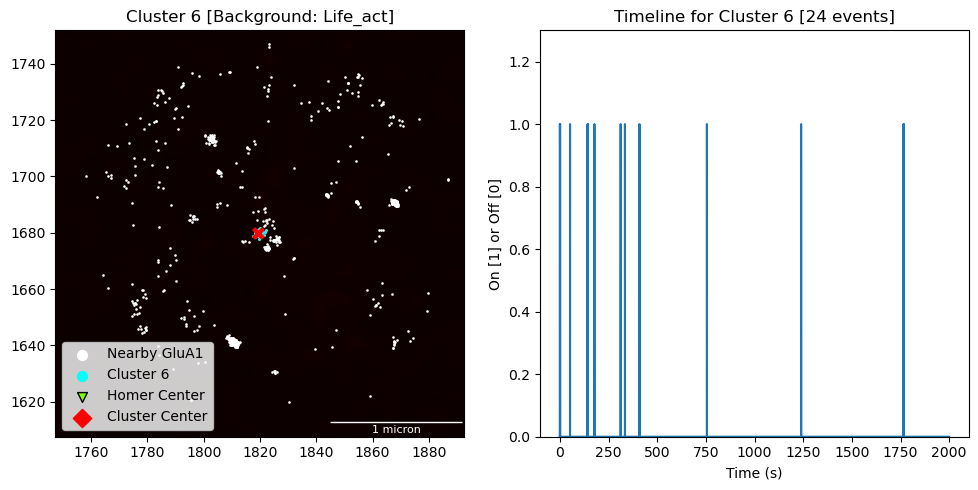

In [221]:
TestFOV.clustering_results[Param][6].plot(buffer=1500, nearby_points=True)

In [8]:
class HomerCenter():
    def __init__(self, center, fov=None, radii=None, points=None, points_label=None, nm_per_pixel=21.34):
        self.center = center
        self.fov = fov
        self.nm_per_pixel = nm_per_pixel
        self.regions = {}
        self.params = []
        if radii is not None:
            self.add_radii(radii)
            if points_label is None:
                self.points_labels = []
            else:
                self.points_labels = [points_label]
                self.add_points(points, points_label)
        else:
            self.points_labels = []
        return
    
    def add_radii(self, radii):
        if type(radii) != list: radii = [radii]
        for radius in radii:
            if radius not in self.regions.keys():
                self.regions[radius] = {}
        return
    
    def add_points(self, points, points_label):
        if points_label is None:
            if self.points_labels == []:
                raise Exception("No existing labels, \'points_label\' needs to be provided with a string labeling the points")
            else:
                points_label = self.points_labels[0]
                warnings.warn(f"No label provided to \'points_label\', assuming points are of label \'{points_label}\'")
        if points_label not in self.points_labels:
            self.points_labels.append(points_label)
        kdtree = KDTree(points)
        for radius in self.regions:
            if points_label not in self.regions[radius]:
                self.regions[radius][points_label] = {}
            points_in_r = points[kdtree.query_ball_point(self.center, radius / self.nm_per_pixel, workers=-1)]
            self.regions[radius][points_label]['points'] = points_in_r
        return

    def add_params(self, params):
        for param in params:
            if param not in self.params:
                self.params.append(param)
        self.params = sorted(self.params, key=lambda x: x[0], reverse=True)
        return
    
    def find_clusters(self, params, points_label=0):
        if type(points_label) == int:
            points_label = self.points_labels[points_label]
        if type(params) != list: params = [params]
        params = sorted(params, key=lambda x: x[0], reverse=True)
        self.add_params(params)
        for i in range(len(params)):
            eps, min_samples = params[i]
            eps = eps/nm_per_pixel
            for radius in self.regions:
                try:
                    self.regions[radius][points_label]['clustering'][params[i]] = {}
                except:
                    self.regions[radius][points_label]['clustering'] = {}
                    self.regions[radius][points_label]['clustering'][params[i]] = {}
                nearby_points = self.regions[radius][points_label]['points']
                clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(nearby_points)
                labels = clustering.labels_
                for j in range(np.max(labels) + 1):
                    cluster_points = nearby_points[labels == j]
                    cluster_indices = 
                    cluster_center = cluster_points.mean(axis=0)
                    self.regions[radius][points_label]['clustering'][params[i]][(cluster_center[0], cluster_center[1])] = cluster_points
        return
    
    def plot_region(self, radii=None, points_label=None, all_points=None, clusters=False, plot_cluster_centers=False, plot_homer_center=True, other_homers=None, 
                    life_act=None, params=[], circle_regions=False, scale_bar=True, legend=True, buffer=50,
                    colors=['purple', 'blue', 'green', 'magenta', 'cyan'], dpi=150, ticks=False, size=0.75):
        
        homer_center = self.center
        if radii is None:
            if list(self.regions.keys()) == []:
                raise Exception("No existing 'radii' and none provided")
            else:
                radii = list(self.regions.keys())
                warnings.warn(f"No radii provided to 'radii', using all current radii: {radii}")
        if type(radii) != list: radii = [radii]
        radii = sorted(radii, reverse=True)
        for radius in radii:
            if radius not in list(self.regions.keys()):
                raise Exception(f"Provided an invalid radius of {radius} nm, this radius has not been processed yet")

        if points_label is None:
            if self.points_labels == []:
                raise Exception("No existing labels, 'points_label' needs to be provided with a string labeling the points")
            else:
                points_label = self.points_labels[0]
                warnings.warn(f"No label provided to 'points_label', assuming points are of label '{points_label}'")
        
        plt.figure(dpi=dpi)
        # Plot Life Act Background
        if life_act is not None:
            plt.imshow(life_act, cmap='hot', origin='lower')
        
        # Set Plot Ranges
        buffer_px = buffer / nm_per_pixel
        vertical_buffer = (max(radii)/self.nm_per_pixel) + buffer_px
        left_buffer = (max(radii)/self.nm_per_pixel) + 0.5*buffer_px
        right_buffer = (max(radii)/self.nm_per_pixel) + 4*buffer_px
        plt.xlim(homer_center[0] - left_buffer, homer_center[0] + right_buffer)
        plt.ylim(homer_center[1] - vertical_buffer, homer_center[1] + vertical_buffer)
        
        # Plot Background Points
        if all_points is None:
            nearby_points = self.regions[max(radii)][points_label]['points']
            plt.scatter(nearby_points[:, 0], nearby_points[:, 1], s=size, color='white', label=f"All Points")
        else:
            plt.scatter(all_points[:, 0], all_points[:, 1], s=size, color='white', label=f"All Points")
        
        #Plot Regional Data (Circles, Clusters)
        if len(radii) == 1:
            radius = radii[0]
            if circle_regions:
                plt.gca().add_artist(plt.Circle(homer_center, radius/self.nm_per_pixel, fill = False, color='red'))
            if clusters:
                if len(params) == 0:
                    keys = list(self.regions[radius][points_label]['clustering'].keys())
                    if len(keys) == 1:
                        params = keys
                        warnings.warn(f"'params' left blank, only one clustering parameter has been run, automatically showing param: {keys[0]}")
                    else:
                        raise Exception("'params' left blank, multiple clustering parameters have been run. you need to provide the parameters of the clustering you want to display")
                params = sorted(params, key=lambda x: x[0], reverse=True)
                for i in range(len(params)):
                    clusters = self.regions[radius][points_label]['clustering'][params[i]]
                    cluster_level_points = []
                    cluster_centers = []
                    for center in clusters:
                        cluster_level_points.extend(clusters[center])
                        cluster_centers.append(center)
                    cluster_level_points = np.array(cluster_level_points)
                    cluster_centers = np.array(cluster_centers)
                    if cluster_level_points.shape == (0, ):
                        print(f"No Clusters in radius [{radius} nm] and with (eps, min_samples) [{params[i]}]")
                    else:
                        plt.scatter(cluster_level_points[:, 0], cluster_level_points[:, 1], color=colors[i], s=size, label=f"Cluster Level {i}")
                    if plot_cluster_centers and cluster_level_points.shape != (0, ):
                        if i > 1:
                            warnings.warn("Cluster center plotting warning: code does not support plotting centers and multiple levels of cluster")
                        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='cyan', s=40, marker='x', label=f"Cluster Centers")
        else:
            if len(params) == 0:
                keys = list(self.regions[radius][points_label]['clustering'].keys())
                if len(keys) == 1:
                    params = keys
                    warnings.warn(f"'params' left blank, only one clustering parameter has been run, automatically showing param: {keys[0]}")
                else:
                    raise Exception("'params' left blank, multiple clustering parameters have been run. you need to provide the parameters of the clustering you want to display")
            elif len(params) > 1:
                raise Exception("Currently no implementation for multiple radii and multiple levels of clustering")
            param = params[0]
            for i in range(len(radii)):
                radius = radii[i]
                if circle_regions:
                    plt.gca().add_artist(plt.Circle(homer_center, radius/self.nm_per_pixel, fill = False, color=colors[i]))
                if clusters:
                    clusters = self.regions[radius][points_label]['clustering'][param]
                    cluster_level_points = []
                    cluster_centers = []
                    for center in clusters:
                        cluster_level_points.extend(clusters[center])
                        cluster_centers.append(center)
                    cluster_level_points = np.array(cluster_level_points)
                    cluster_centers = np.array(cluster_centers)
                    if cluster_level_points.shape == (0, ):
                        print(f"No Clusters in radius [{radius} nm] and with (eps, min_samples) [{param}]")
                    else:
                        plt.scatter(cluster_level_points[:, 0], cluster_level_points[:, 1], color=colors[i], s=size, label=f"Clusters Within {radius} nm")
                    if plot_cluster_centers and cluster_level_points.shape != (0, ):
                        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='cyan', s=40, marker='x', label=f"Cluster Centers Within {radius} nm")
                
        # Plotting Homer Centers
        if other_homers is None and plot_homer_center:
            plt.scatter(homer_center[0], homer_center[1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")
        else:
            plt.scatter(other_homers[:, 0], other_homers[:, 1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Centers")
        
        # Plotting Scale Bar
        if scale_bar:
            fontprops = fm.FontProperties(size=8)
            scalebar = AnchoredSizeBar(plt.gca().transData,
                                    1000/nm_per_pixel,  # length of scale bar
                                    '1 micron',  # label
                                    'lower right',  # position
                                    pad=0.1,
                                    color='white',
                                    frameon=False,
                                    size_vertical=0.05,
                                    fontproperties=fontprops)
            plt.gca().add_artist(scalebar)
        
        # Setting axis ticks
        if not ticks:
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        
        # Setting legend and adjusting handle sizes
        if legend:
            for handle in plt.legend(loc='upper right', fontsize=7).legend_handles:
                handle._sizes = [50]
        plt.show()


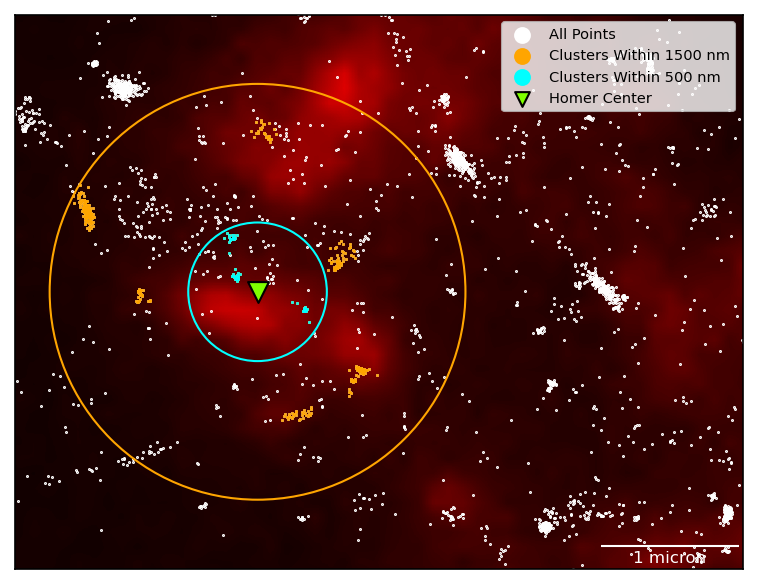

In [9]:
test_center = HomerCenter(homer_centers_px[16], radii=[500, 1500], points=raw_GluA1_pts, points_label='GluA1')
params = [(80, 20)]
test_center.find_clusters(params=params)
test_center.plot_region(radii=[500, 1500], points_label='GluA1', all_points=raw_GluA1_pts, clusters=True, plot_cluster_centers=False, plot_homer_center=True, other_homers=None, 
                    life_act=life_act, params=params, circle_regions=True, scale_bar=True, legend=True, buffer=500,
                    colors=['orange', 'aqua', 'magenta', 'magenta', 'cyan'], dpi=150, ticks=False, size=0.2)

In [11]:
test_FOV = FieldOfView(homer_centers_px, life_act, threshold=900)

In [230]:
def plot_multi_level_clustering(neighborhood, buffer=50, life_act=life_act, all_points=None, scale_bar=True, colors=['yellow', 'orange', 'red']):
    homer_center = neighborhood['Homer Center']
    nearby_points = neighborhood['Nearby Points']
    radius = neighborhood['Radius']
    buffer = buffer + radius
    cluster_points = []
    for i in range(0, int((len(neighborhood)-3)/2)):
        cluster_points.append([list(point) for sublist in neighborhood[f'Cluster Points {i}'] for point in sublist])

    plt.figure(dpi=150)
    plt.imshow(life_act, cmap='magma', origin='lower')
    plt.xlim(homer_center[0] - buffer, homer_center[0] + 1.5*buffer)
    plt.ylim(homer_center[1] - buffer, homer_center[1] + buffer)
    plt.gca().add_artist(plt.Circle(homer_center, radius, fill = False, color='red'))
    if all_points is None:
        plt.scatter(nearby_points[:, 0], nearby_points[:, 1], s=0.75, color='white', label=f"All Points")
    else:
        plt.scatter(all_points[:, 0], all_points[:, 1], s=0.75, color='white', label=f"All Points")
    for i in range(len(cluster_points)):
        points = np.array(cluster_points[i])
        if points.shape != (0, ):
            plt.scatter(points[:, 0], points[:, 1], color=colors[i], s=0.75, label=f"Level {i}")
    plt.scatter(homer_center[0], homer_center[1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")
    if scale_bar:
        fontprops = fm.FontProperties(size=8)
        scalebar = AnchoredSizeBar(plt.gca().transData,
                                1000/nm_per_pixel,  # length of scale bar
                                '1 micron',  # label
                                'lower right',  # position
                                pad=0.1,
                                color='white',
                                frameon=False,
                                size_vertical=0.05,
                                fontproperties=fontprops)
        plt.gca().add_artist(scalebar)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.legend()
    for handle in plt.legend().legend_handles:
        handle._sizes = [100]
    plt.show()

In [150]:
def plot_homer_neighborhood(neighborhood, buffer=50, life_act=life_act, scale_bar=True):
    homer_center = neighborhood['Homer Center']
    nearby_points = neighborhood['Nearby Points']
    cluster_centers = neighborhood['Cluster Centers']
    cluster_points = neighborhood['Cluster Points']
    radius = neighborhood['Radius']
    buffer = buffer + radius
    plt.figure(dpi=150)
    plt.imshow(life_act, cmap='magma', origin='lower')
    plt.xlim(homer_center[0] - buffer, homer_center[0] + 1.5*buffer)
    plt.ylim(homer_center[1] - buffer, homer_center[1] + buffer)
    small_circle = plt.Circle(homer_center, radius, fill = False, color='red')
    plt.gca().add_artist(small_circle)
    plt.scatter(nearby_points[:, 0], nearby_points[:, 1], s=0.75, color='white', label=f"All Points")
    for i in range(len(cluster_centers)):
        plt.scatter(cluster_points[i][:, 0], cluster_points[i][:, 1], s=0.75, label=f"Cluster {i}")
        plt.scatter(cluster_centers[i][0], cluster_centers[i][1], marker='x', color='red')
    plt.scatter(homer_center[0], homer_center[1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if scale_bar:
        fontprops = fm.FontProperties(size=8)
        scalebar = AnchoredSizeBar(plt.gca().transData,
                                1000/nm_per_pixel,  # length of scale bar
                                '1 micron',  # label
                                'lower right',  # position
                                pad=0.1,
                                color='white',
                                frameon=False,
                                size_vertical=0.05,
                                fontproperties=fontprops)
        plt.gca().add_artist(scalebar)
    plt.legend()
    for handle in plt.legend().legend_handles:
        handle._sizes = [100]
    plt.show()

In [145]:
close_cluster_params = {'eps': 80, 'min_samples': 10, 'radius': 500}
far_cluster_params = {'eps': 80, 'min_samples': 10, 'radius': 1500}

close_homer_neighborhoods = find_homer_neighborhood(relevant_homer_centers, raw_GluA1_pts, close_cluster_params)
far_homer_neighborhoods = find_homer_neighborhood(relevant_homer_centers, raw_GluA1_pts, far_cluster_params)

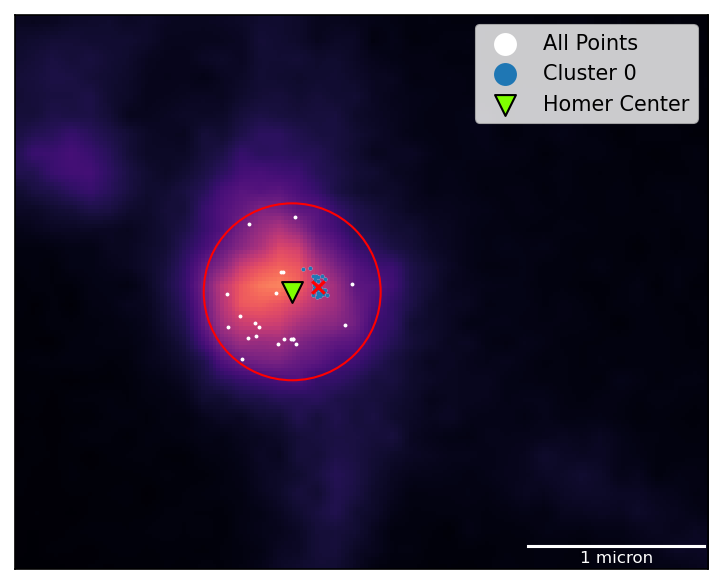

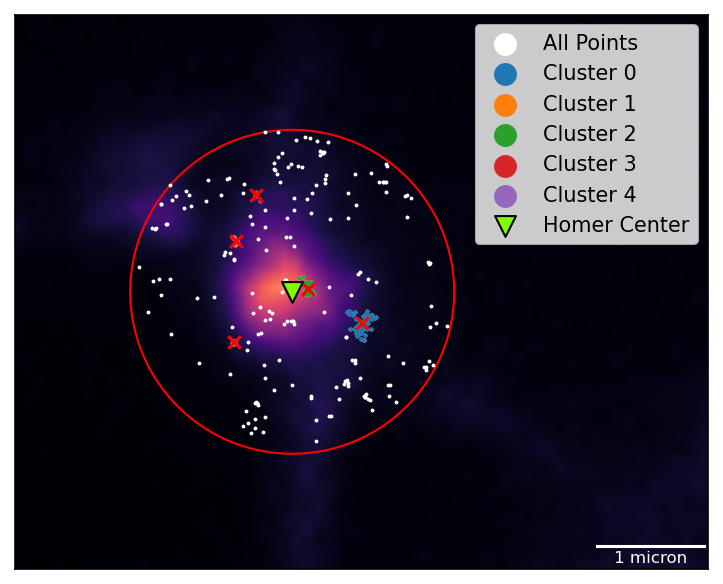

In [151]:
index = 4
plot_homer_neighborhood(close_homer_neighborhoods[index])
plot_homer_neighborhood(far_homer_neighborhoods[index])

In [ ]:
def multi_level_clustering(homer_centers, points, cluster_params):
    neighborhoods = []
    for params in cluster_params:
        neighborhoods.append(find_homer_neighborhood(homer_centers, points, params))
    to_return = []
    for i in range(len(homer_centers)):
        dictionary = {'Homer Center': neighborhoods[0][i]['Homer Center'], 'Radius': neighborhoods[0][i]['Radius'], 'Nearby Points': neighborhoods[0][i]['Nearby Points']}
        for j in range(len(neighborhoods)):
            dictionary[f'Cluster Centers {j}'] = neighborhoods[j][i]['Cluster Centers']
            dictionary[f'Cluster Points {j}'] = neighborhoods[j][i]['Cluster Points']
        to_return.append(dictionary)
    return to_return

In [222]:
cluster_params = [{'eps': 150, 'min_samples': 10, 'radius': 1500},
                  {'eps': 120, 'min_samples': 20, 'radius': 1500},
                  {'eps': 80, 'min_samples': 30, 'radius': 1500}]
multi_level_neighborhoods = multi_level_clustering(relevant_homer_centers, raw_GluA1_pts, cluster_params)

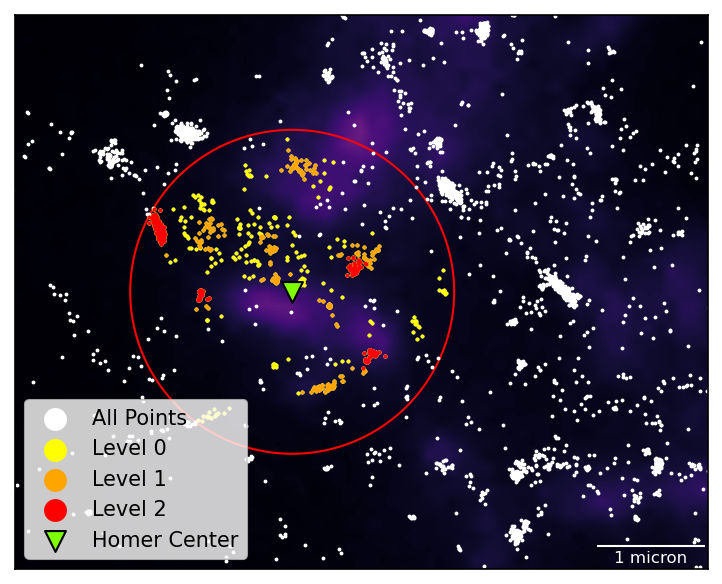

In [231]:
index = 5
plot_multi_level_clustering(multi_level_neighborhoods[index], all_points=raw_GluA1_pts)